In [1]:
import cv2 as cv2
import numpy as np
import matplotlib.pyplot as plt
from f1tenth_gym.envs.track import Track
from scipy.interpolate import CubicSpline
import time

In [2]:
def to_img(x, y, origin):
    dx = x - origin[0]
    dy = y - origin[1]
    c = np.cos(-origin[2])
    s = np.sin(-origin[2])
    x = c * dx - s * dy
    y = s * dx + c * dy
    scale = 0.05
    x = (x / scale) 
    y = (y / scale)
    return x, y

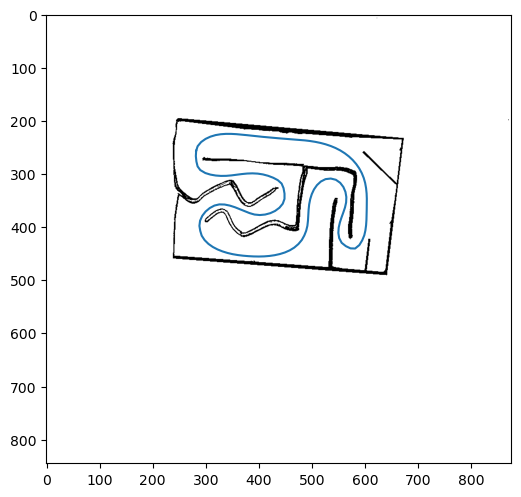

In [3]:
map = '/Users/bryanalfaro/Documents/Problem_Sets/f1_final/f1tenth_gym/maps/race3/race3.png'
map_np = plt.imread(map)
raceline = np.loadtxt('/Users/bryanalfaro/Documents/Problem_Sets/f1_final/f1tenth_gym/maps/race3/race3_raceline.csv', delimiter=';')
origin = [-20, -12.6, 0]
x, y = to_img(raceline[:, 1], raceline[:, 2], origin)
plt.figure(figsize=(6,6))


track = Track.from_track_name("race3")
plt.plot(x, y)
plt.imshow(track.occupancy_map, cmap='gray')


In [4]:
def _get_yaw_spline(raceline_info):
    data = np.zeros((raceline_info.shape[0], 2))
    data[:, 0] = raceline_info[:, 0] # s
    data[:, 1] = raceline_info[:, 3] # yaw
    data = data[data[:, 0].argsort()]
    data = data[:-1]
    return CubicSpline(data[:, 0], data[:, 1])
yaw_spline = _get_yaw_spline(raceline)

In [9]:
def _spawn_obstacle(
        track : Track,
        centerline,
        yaw_spline : CubicSpline,
        n_obs = 10,
        obs_room = 30,
        room=10, 
        r_min=0.15,
        r_max=0.3,
        margin=0.6,
    ):
        """
        spawns a random box on track room away from ego
        only draws circles for now, with low lidar resolution should be fine

        Args:
            obs_room: minimum number of indices separating the sampled centerline points for the obstacles
            room (int): minimum distance in indices from ego to spawn location 
            r_min (float): minimum obstacle size
            margin (float): how much track width to leave on either side of the circle
        """
        # ego_x, ego_y = self.start_xs[self.ego_idx], self.start_ys[self.ego_idx] #, self.poses_yaw[self.ego_idx]
        # pt = np.array([ego_x, ego_y])
        # _, _, _, n_idx = nearest_point_on_trajectory(pt.astype(np.float64), self.centerline[:, :2].astype(np.float64))

        # deletes indices in B_r(pt) from selection pool
        # TODO: idk if these checks are necessary,
        # agent reset might account for updated occupancy map
        # track.centerline.
        curr = track.occupancy_map
        idxs = np.arange(len(centerline))
        for i in range(n_obs):
            
            # close = idxs.take(np.arange(n_idx - room, n_idx + room + 1), mode='wrap')
            # idxs = np.delete(idxs, close)

            # randomly select (s, ey) from remaining indices
            rand_idx = np.random.choice(idxs)

            # exclude next ones in next iteration
            remove_window = np.arange(rand_idx - obs_room, rand_idx + obs_room + 1)
            remove_window[remove_window < 0] += centerline.shape[0]
            remove_window[remove_window > centerline.shape[0]] -= centerline.shape[0]
            idxs = np.setdiff1d(idxs, remove_window)

            # print(rand_idx)
            xc, yc = centerline[rand_idx, :2]
            s, _ = track.centerline.spline.calc_arclength_inaccurate(xc, yc)
            yaw = yaw_spline(s)    
            # print(np.rad2deg(yaw)%360)
            # print(yaw)
            # xcp1, ycp1 = centerline[(rand_idx + 1) % centerline.shape[0], :2]
            
            # yaw = np.arctan2(ycp1 - yc, xcp1 - xc)
            wl, wr = centerline[rand_idx, 2:4] # track width at (xc, yc)
            # s, _, _ = track.cartesian_to_frenet(xc, yc, yaw)
            # print(s)
            ey = np.random.uniform(-wr, wl)
            # direction = 'left' if ey > 0 else 'right'
            # print(direction)
            dx = -ey * np.sin(yaw)
            dy = ey * np.cos(yaw)
            # print(dx, dy)
            x = xc + dx
            y = yc + dy
            # print(-wr <= ey <= wl)
            # print(f'{xc}, {yc}')
            
            # x, y, _ = track.frenet_to_cartesian(s, ey, 0.0)
            # print(np.linalg.norm([x - xc, y-yc], 2))

            # print(f'{x}, {y}')
            # select appropriate radius using track width and ey
            # if ey < 0: # leave RHS clear
            #     r_max = wr - np.abs(ey) - margin
            # else: # leave LHS clear
            #     r_max = wl - np.abs(ey) - margin
            # leave a gap of at least size margin:
            # r_max = (wl + wr - 2 * margin) / 2
            # r_max = max(r_min, r_max) # to ensure nonnegative
            r = np.random.uniform(r_min, r_max)
            curr = _draw_circle(track, x, y, r)
        return curr

def _draw_circle(track : Track, x, y, r):
    """draws circle on the occupancy grid"""
    scale = track.spec.resolution # conversion faactor pixel -> m
    ox, oy, yaw = track.spec.origin
    if r < 0.0:
        r = 0.0
    r = int(r / scale)
    dx = x - ox
    dy = y - oy
    c = np.cos(-yaw)
    s = np.sin(-yaw)
    x = c * dx - s * dy
    y = s * dx + c * dy
    x = int(x / scale) 
    y = int(y / scale)
    return cv2.circle(track.occupancy_map, (x, y), r, 0.0, -1)


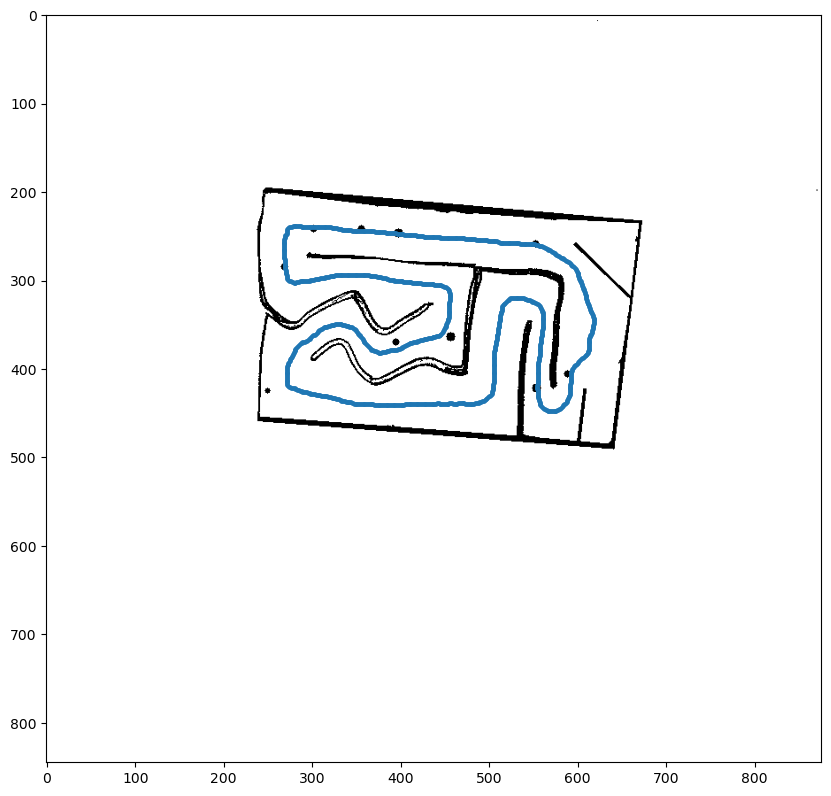

In [11]:
# import time
map = '/Users/bryanalfaro/Documents/Problem_Sets/f1_final/f1tenth_gym/maps/race3/race3.png'
map_np = plt.imread(map)
# plt.figure()
# plt.imshow(map_np, cmap='gray')
track = Track.from_track_name("race3")
origin = [-20, -12.6, 0]

centerline = np.loadtxt('/Users/bryanalfaro/Documents/Problem_Sets/f1_final/f1tenth_gym/maps/race3/race3_centerline.csv', delimiter=',').astype(np.float32)
dx = centerline[:, 0] - origin[0]
dy = centerline[:, 1] - origin[1]
c = np.cos(-origin[2])
s = np.sin(-origin[2])
x = c * dx - s * dy
y = s * dx + c * dy
scale = 0.05
x = (x / scale) 
y = (y / scale)
n = 10
samples = np.zeros((2,n))
# for i in range(n):
track.occupancy_map = _spawn_obstacle(track, centerline, yaw_spline, n_obs=n)
# xc, yc = to_img(xc, yc, origin)
# xs, ys = to_img(xs, ys, origin)
# samples[0, i] = xc
# samples[1, i] = yc
plt.figure(figsize=(10, 10))
plt.imshow(track.occupancy_map, cmap='gray')
# plt.scatter(samples[0], samples[1])
# plt.scatter(x, y, s=0.01)
# x = track.centerline.xs
# y = track.centerline.ys
x, y = to_img(centerline[:, 0], centerline[:, 1], origin)
plt.scatter(x, y, s=5)
    # plt.scatter(xc, yc, color='b', s=10) # should give randomly sampled point on centerline
    # plt.scatter(xs, ys, color='g', s=10) # should give perturbation of above point
    # plt.show()
    # time.sleep(1)
    # plt.clf()
    

    # time.sleep(1)
# plt.figure()xs

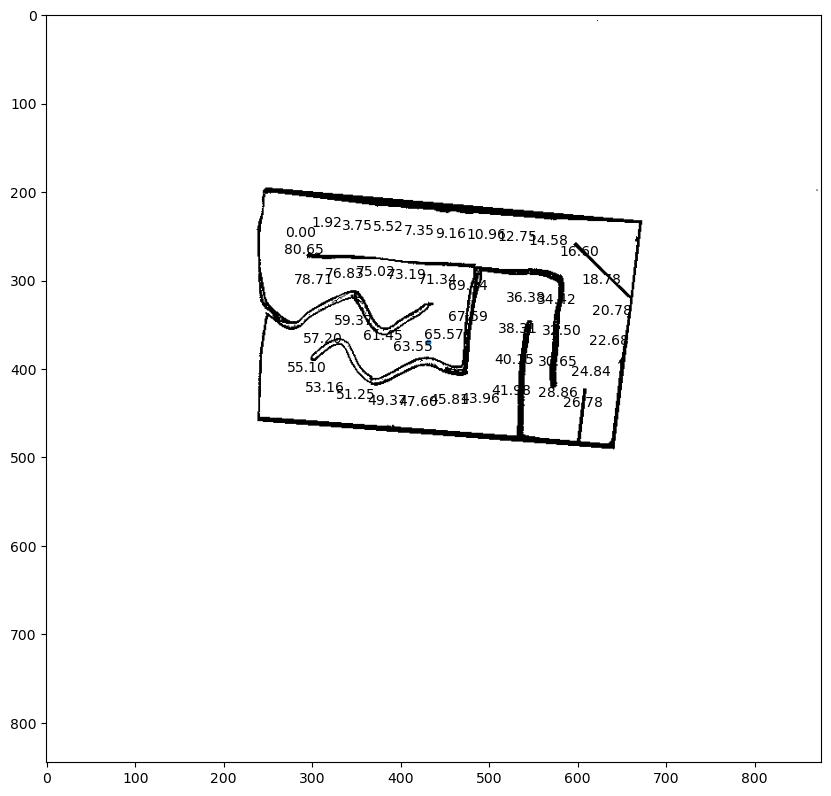

In [7]:
# visualize the s-values of each point along the centerline
# plt.figure(figsize=(10, 10))
fig, ax = plt.subplots(figsize = (10,10))
ax.imshow(track.occupancy_map, cmap='gray')
# plt.scatter(samples[0], samples[1])
s = []
xc = centerline[:, 0]
yc = centerline[:, 1]
for i in range(len(x)):
    s.append(track.centerline.spline.calc_arclength_inaccurate(xc[i], yc[i])[0])
    # print(s[i])
# visualizing bad rl pose:
xp, yp = 1.518377661705017, 5.857672691345215
xp, yp = to_img(xp, yp, origin)
plt.scatter(xp, yp, s=10)
# plt.scatter(x, y, s=0.01)
for i in range(0, len(x), 35):
    ax.annotate('%.2f' % s[i], (x[i], y[i]))

In [8]:
# testing index exclusion
idxs = np.arange(100)

sampled_idx = 0
window = 5
idxs_to_remove = np.arange(sampled_idx - window, sampled_idx + window + 1)
idxs_to_remove[idxs_to_remove < 0] += 100 # add back in length of array
idxs = np.setdiff1d(idxs, idxs_to_remove)
print(idxs)

sampled_idx = 9
window = 5
idxs_to_remove = np.arange(sampled_idx - window, sampled_idx + window + 1)
idxs_to_remove[idxs_to_remove < 0] += 100 # add back in length of array
idxs = np.setdiff1d(idxs, idxs_to_remove)
print(idxs)
# remove = idxs[(5 <= idxs)  & (idxs <= 15)]
# idxs = np.setdiff1d(idxs, remove)
# print(idxs)



# print(idxs)
# for i in range(1, 6):
#     idxs = np.delete(idxs, idxs.take((10-i, 10+i), mode='wrap'))
# print(idxs)
# print(np.delete(idxs, idxs.take((10 - 5, 10 + 5), mode='wrap')))
# print(np.delete(idxs, idxs.take((50 - 5, 50 + 5), mode='wrap')))


[ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77
 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94]
[15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38
 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62
 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86
 87 88 89 90 91 92 93 94]
